In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 

### Helper functions

In [3]:
def distance(xs, centroid):
    """Computes matrix of squared distance from each point to each centroid.
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    
    Returns:
    --------
    distance: matrix of squared distances (nxk)
    """

    distance = np.sum((xs[:,None,:] - centroid)**2, axis=-1)
    return distance

In [4]:
def cost(d):
    """Computes the cost of a set of points with respect to a collection of centroids
    
    Parameters:
    -----------
    d : matrix of squared distances (nxk); likely returned from distance() function
    
    Returns:
    --------
    cost: cost with respect to centroids
    """
    #calculate distance to the nearest centroid for each point
    min_dist = np.min(d, axis = 1)
    
    #compute cost
    cost = np.sum(min_dist)
    return cost

In [5]:
def centroid_weights(d):
    """Computes weights as defined in step 7 of the k-means|| algorithm
        
    Parameters:
    -----------
    d : matrix of squared distances (nxk); likely returned from distance() function
    
    Returns:
    --------
    w_x: ndarray of weights applied to centroids (kx1)
    """
    #identify closest centroid to each point
    c_close = np.zeros(d.shape)
    c_close[np.arange(d.shape[0]), np.argmin(d, axis = 1)] = 1
    
    #compute the weights
    w_x = np.sum(c_close, axis = 0)
    return w_x

### K-means ++ initialization (Section 3.1)

In [6]:
def k_means_pp(xs, k, seed=None):
    """
    Implements the K_means++ Initialization algorithm
    
    Parameters:
    -----------
    xs: input dataset
    k: the number of output clusters
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    #initialization
    np.random.seed(seed)
    C = xs[np.random.choice(xs.shape[0],1),:]
    loop = 0
    
    while len(C)<k:
        
        if (loop % 10 == 0):
            print("The current loop is:", loop)
        
        dist = distance(xs,C)
        cst = cost(dist)
        
        probs_x = np.min(dist, axis = 1)/cst
        C_new = xs[np.random.choice(xs.shape[0],1,p=probs_x),:]
        
        C = np.vstack((C,C_new))
        
        loop += 1
        
    return C

### K-means || initialization (Section 3.3)

In [7]:
def K_Means_parallel(xs, k, l, seed=None):
    """Implements the K_means || algorithm
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    order = np.log10(cost(distance(xs,centroid)))
    
    ##should we add condition to run minimum # of times unless dataset sufficiently large?
    
    for i in np.arange(np.round(order)):
        dist = distance(xs,centroid)
        cst = cost(dist)
        
        probs_x = np.min(dist, axis = 1)/cst
        centroid_new = xs[np.random.choice(xs.shape[0],l,p=probs_x),:]
        
        centroid = np.vstack((centroid,centroid_new))
        
    dist = distance(xs,centroid)
    weight = centroid_weights(dist)
    
    #Implement k-means++ to recluster weighted points in C
    w_C = weight[:,None]*centroid
    C = k_means_pp(w_C,k,seed=seed)
    #C = centroid[np.random.choice(centroid.shape[0],k,replace=False,p=weight),:]
    return C

### K-means Algorithm

In [8]:
def k_means(X, k, centroids):
    """
        This function will separate X into k clusters using the classic k-means
        algorithm.
    """
    ## parameters
    max_iter = 1000
    step = 0
    #n, p = X.shape
    
    ## run the algorithm
    while step < max_iter:
        ### sort the data in terms of clusters
        dist = distance(X, centroids)
        cluster_indices = np.argmin(dist, axis=1)
        
        ### update centroids
        update_centroids = np.zeros(centroids.shape)
        for i in range(k):
            update_centroids[i,:] = np.mean(X[cluster_indices==i,:], axis=0)
        
        ### check conditions
        if np.array_equal(update_centroids, centroids):
            break
        else:
            centroids = update_centroids
            
            if (step % 5 == 0):
                print("We are currently at {} step".format(step))
            
            step += 1
    
    total_dist = distance(X, centroids)
            
    return {"Centroids": centroids,
            "Cluster Indices": cluster_indices,
            "Number of Iterations": step}

### The Parallel Implementation (Section 3.5)

### Multiprocessing

In [12]:
from multiprocessing import Pool, cpu_count
from functools import partial
from collections import Counter

#### Helper functions

In [13]:
def min_dist(point, centroid):
    """Computes the squared distance to the nearest centroid for a given data point"""
    min_dist = np.min(np.sum((point - centroid)**2, axis=-1))
    return min_dist

def close_cent(point, centroid):
    """Returns the index of the closest centroid to a given data point"""
    index = np.argmin(np.sum((point - centroid)**2, axis=-1))
    return index

#### Functions in Parallel

In [14]:
def probs_x_p(xs, centroid, cpu=None):
    """Computes the probabilities for sampling a new centroid(s)
    for a given set of centroids and the data in parallel
    
    Also returns the intermediary cost value
    """
    p_min_dist = partial(min_dist, centroid=centroid)
    with Pool(processes = cpu) as pool:
        min_d = pool.map(p_min_dist,xs)
        cost = np.sum(min_d)
        prob_x = min_d/cost
    return cost, prob_x

In [15]:
def weights_p(xs, centroid, cpu=None):
    """Computes the weights for each centroid in parallel"""
    
    p_close_cent = partial(close_cent, centroid=centroid)
    with Pool(processes = cpu) as pool:
        indeces = pool.map(p_close_cent, xs)
        w_x = np.array([Counter(indeces)[i] for i in np.arange(centroid.shape[0])])
    return w_x

In [16]:
def K_Means_parallel_p(xs, k, l, seed=None):
    """Implements the K_means || algorithm using parallel intermediary functions
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    order = np.log10(probs_x_p(xs,centroid)[0])
    
    ##should we add condition to run minimum # of times unless dataset sufficiently large?
    
    for i in np.arange(np.round(order)):
        
        probs_x = probs_x_p(xs,centroid)[1]
        centroid_new = xs[np.random.choice(xs.shape[0],l,p=probs_x),:]
        
        centroid = np.vstack((centroid,centroid_new))
        
    weight = weights_p(xs,centroid)
    
    #Implement k-means++ to recluster weighted points in C
    w_C = weight[:,None]*centroid
    C = k_means_pp(w_C,k,seed=seed)
    #C = centroid[np.random.choice(centroid.shape[0],k,replace=False,p=weight),:]
    return C

In [17]:
xs = GM[0] #data is from GaussMix dataset
cent = xs[np.random.choice(xs.shape[0],5),:]

probs_x_p(xs,cent)

(837670.8398204267, array([3.91441064e-05, 6.68560880e-05, 3.37563899e-04, ...,
        3.48420725e-04, 4.58257044e-05, 3.56298600e-05]))

In [18]:
weights_p(xs,cent)

array([ 910, 2003, 2000, 1197, 3890])

### Using iPyParallel

In [9]:
from ipyparallel import Client
rc = Client()
dv = rc[:]
with dv.sync_imports():
    import numpy

rc.ids

importing numpy on engine(s)


[0, 1, 2, 3, 4, 5, 6, 7]

In [27]:
def min_dist_ipy(point, centroid):
    """Computes the squared distance to the nearest centroid for a given data point"""
    min_dist = numpy.min(numpy.sum((point - centroid)**2, axis=-1))
    return min_dist

def close_cent_ipy(point, centroid):
    """Returns the index of the closest centroid to a given data point"""
    index = numpy.argmin(numpy.sum((point - centroid)**2, axis=-1))
    return index

In [28]:
def probs_x_ipy(xs, centroid, cpu=None):
    """Computes the probabilities for sampling a new centroid(s)
    for a given set of centroids and the data in parallel
    
    Also returns the intermediary cost value
    """
    p_min_dist = partial(min_dist_ipy, centroid=centroid)
    min_d = dv.map_sync(p_min_dist,xs)
    
    cost = numpy.sum(min_d)
    prob_x = min_d/cost
    return cost, prob_x

In [29]:
def weights_ipy(xs, centroid, cpu=None):
    """Computes the weights for each centroid in parallel"""
    
    p_close_cent = partial(close_cent_ipy, centroid=centroid)
    indeces = dv.map_sync(p_close_cent, xs)
    
    #w_x = np.array([Counter(indeces)[i] for i in np.arange(centroid.shape[0])])
    return indeces

In [30]:
p_min_dist_ipy = partial(min_dist_ipy, centroid=cent)
probs_x_ipy(xs,cent)

(837670.8398204267, array([3.91441064e-05, 6.68560880e-05, 3.37563899e-04, ...,
        3.48420725e-04, 4.58257044e-05, 3.56298600e-05]))

In [31]:
def K_Means_parallel_ipy(xs, k, l, seed=None):
    """Implements the K_means || algorithm using parallel intermediary functions
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    order = np.log10(probs_x_ipy(xs,centroid)[0])
    
    ##should we add condition to run minimum # of times unless dataset sufficiently large?
    
    for i in np.arange(np.round(order)):
        
        probs_x = probs_x_ipy(xs,centroid)[1]
        centroid_new = xs[np.random.choice(xs.shape[0],l,p=probs_x),:]
        
        centroid = np.vstack((centroid,centroid_new))
        
    idx = weights_ipy(xs,centroid)
    weight = np.array([Counter(idx)[i] for i in np.arange(centroid.shape[0])])
    
    #Implement k-means++ to recluster weighted points in C
    w_C = weight[:,None]*centroid
    C = k_means_pp(w_C,k,seed=seed)
    #C = centroid[np.random.choice(centroid.shape[0],k,replace=False,p=weight),:]
    return C

In [33]:
%%time

K_Means_parallel_ipy(xs1,5,5,seed=123)

The current loop is: 0
CPU times: user 1.46 s, sys: 188 ms, total: 1.64 s
Wall time: 4.1 s


array([[-7.44992825e+03,  4.03629313e+04,  3.73808980e+04,
         1.33943294e+04,  4.84431181e+03,  1.37900578e+04,
         2.74058835e+04, -1.51410680e+04,  2.20034565e+04,
        -6.09052906e+03, -1.53963534e+04,  1.83985015e+04,
        -2.09587137e+04, -1.08374288e+03, -1.07295114e+04],
       [-6.04124397e+02, -1.28123432e+04, -7.66599804e+03,
        -2.31026745e+02,  8.82669657e+03, -5.06576602e+02,
         9.79229253e+00,  3.83950051e+03, -3.89596769e+03,
         6.04096178e+02, -5.87893483e+03, -8.15588540e+03,
        -1.31719590e+03,  3.55989418e+03,  9.43725732e+02],
       [-1.90461338e+04,  2.27233223e+04,  7.19857773e+03,
        -2.61452096e+04, -5.37883688e+03,  2.69764139e+04,
        -4.29818633e+04, -6.92690640e+03,  1.78442454e+04,
        -1.66627626e+04, -1.83208584e+04, -4.96664095e+03,
         1.79404936e+04, -1.05118512e+04, -1.19842132e+04],
       [-1.68155629e+04, -8.05250276e+04, -3.77052060e+04,
        -1.51510374e+04,  2.64779315e+04, -1.08717892

### Using the Parallel Decorator

In [ ]:
@dv.parallel(block = True)
def f4(x, y):
    return x+y


#f4(np.arange(10),np.arange(10))
cent

In [19]:
mydict=dict(centroid=cent)
dv.push(mydict)

@dv.parallel(block=True)
def distance_ll(x):
    dist = numpy.sum((x[:,None,:] - centroid)**2, axis=-1)
    return dist


@dv.parallel(block=True)
def cost_ll(dist):
    min_dist = numpy.min(dist, axis=1)
    cost = numpy.sum(min_dist)
    return cost

@dv.parallel(block=True)
def weights_ll(dist):
    c_close = numpy.zeros(dist.shape)
    c_close[numpy.arange(dist.shape[0]), numpy.argmin(dist, axis = 1)] = 1
    
    return c_close


In [20]:
def K_Means_parallel_ll(xs, k, l, seed=None):
    """Implements the K_means || algorithm using parallel intermediary functions
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    dv.push(dict(centroid=centroid))
    order = np.log10(np.sum(cost_ll(distance_ll(xs))))
    
    for i in np.arange(np.round(order)):
        
        
        dist = distance_ll(xs)
        probs_x = np.min(dist, axis = 1)/np.sum(cost_ll(dist))
        centroid_new = xs[np.random.choice(xs.shape[0],l,p=probs_x),:]
        
        centroid = np.vstack((centroid,centroid_new))
        dv.push(dict(centroid=centroid))
    
    weight = np.sum(weights_ll(distance_ll(xs)),axis=0)
    
    #Implement k-means++ to recluster weighted points in C
    w_C = weight[:,None]*centroid
    C = k_means_pp(w_C,k,seed=seed)
    return C

In [22]:
xs = GM[0]
xs1 = GaussMix(10,k,n=100000,seed=123)[0]

In [25]:
%%time

K_Means_parallel(xs1, k=5, l=5, seed=123)

The current loop is: 0
CPU times: user 1.74 s, sys: 352 ms, total: 2.1 s
Wall time: 2.1 s


array([[-7.44992825e+03,  4.03629313e+04,  3.73808980e+04,
         1.33943294e+04,  4.84431181e+03,  1.37900578e+04,
         2.74058835e+04, -1.51410680e+04,  2.20034565e+04,
        -6.09052906e+03, -1.53963534e+04,  1.83985015e+04,
        -2.09587137e+04, -1.08374288e+03, -1.07295114e+04],
       [-6.04124397e+02, -1.28123432e+04, -7.66599804e+03,
        -2.31026745e+02,  8.82669657e+03, -5.06576602e+02,
         9.79229253e+00,  3.83950051e+03, -3.89596769e+03,
         6.04096178e+02, -5.87893483e+03, -8.15588540e+03,
        -1.31719590e+03,  3.55989418e+03,  9.43725732e+02],
       [-1.90461338e+04,  2.27233223e+04,  7.19857773e+03,
        -2.61452096e+04, -5.37883688e+03,  2.69764139e+04,
        -4.29818633e+04, -6.92690640e+03,  1.78442454e+04,
        -1.66627626e+04, -1.83208584e+04, -4.96664095e+03,
         1.79404936e+04, -1.05118512e+04, -1.19842132e+04],
       [-1.68155629e+04, -8.05250276e+04, -3.77052060e+04,
        -1.51510374e+04,  2.64779315e+04, -1.08717892

In [26]:
%%time

K_Means_parallel_ll(xs1, k=5, l=5, seed=123)

The current loop is: 0
CPU times: user 1.02 s, sys: 368 ms, total: 1.38 s
Wall time: 1.9 s


array([[-7.44992825e+03,  4.03629313e+04,  3.73808980e+04,
         1.33943294e+04,  4.84431181e+03,  1.37900578e+04,
         2.74058835e+04, -1.51410680e+04,  2.20034565e+04,
        -6.09052906e+03, -1.53963534e+04,  1.83985015e+04,
        -2.09587137e+04, -1.08374288e+03, -1.07295114e+04],
       [-6.04124397e+02, -1.28123432e+04, -7.66599804e+03,
        -2.31026745e+02,  8.82669657e+03, -5.06576602e+02,
         9.79229253e+00,  3.83950051e+03, -3.89596769e+03,
         6.04096178e+02, -5.87893483e+03, -8.15588540e+03,
        -1.31719590e+03,  3.55989418e+03,  9.43725732e+02],
       [-1.90461338e+04,  2.27233223e+04,  7.19857773e+03,
        -2.61452096e+04, -5.37883688e+03,  2.69764139e+04,
        -4.29818633e+04, -6.92690640e+03,  1.78442454e+04,
        -1.66627626e+04, -1.83208584e+04, -4.96664095e+03,
         1.79404936e+04, -1.05118512e+04, -1.19842132e+04],
       [-1.68155629e+04, -8.05250276e+04, -3.77052060e+04,
        -1.51510374e+04,  2.64779315e+04, -1.08717892

### Generate GaussMixture synthetic data for testing (Section 4.1)

In [10]:
def GaussMix(R, k, n=10000, d=15, seed=None):
    """Generates GaussMixture synthetic dataset"""
    np.random.seed(seed)
    mu = np.zeros(d)
    sigma = np.diag(R*np.ones(d))
    centers = np.random.multivariate_normal(mean=mu, cov=sigma, size=k)
    
    X,y = make_blobs(n_samples=n, n_features=d, centers=centers, random_state=seed)
    return X,y

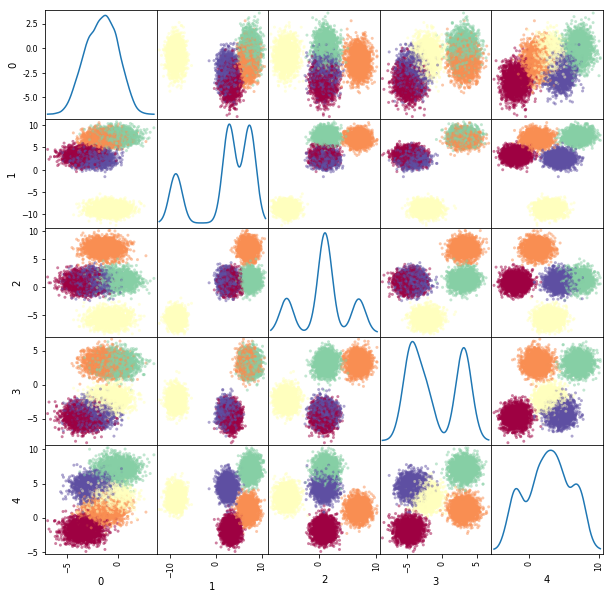

In [11]:
k=5
GM = GaussMix(10,k,seed=123)
df = pd.DataFrame(GM[0])
y = GM[1]
pd.plotting.scatter_matrix(df.iloc[:,0:5], c=y, figsize=(10,10),
                           diagonal='kde', alpha=0.5, cmap='Spectral')
pass

In [ ]:
#using a random initialization
xs = GM[0]
np.random.seed(12345)
c_int = xs[np.random.choice(xs.shape[0],k,replace=False),:]
pred = k_means(xs,k,c_int)

In [ ]:
from sklearn.cluster import KMeans

plib = KMeans(k,init='random',random_state=12345,n_init=1).fit(xs)
plib.labels_

In [ ]:
colors = plt.cm.Spectral(np.linspace(0,1,k))
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([xs[j,0:2] for j in range(xs.shape[0]) if plib.labels_[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(plib.cluster_centers_[:,0], plib.cluster_centers_[:,1], marker='*', s=200, c='#050505')
pass

In [ ]:
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([xs[j,0:2] for j in range(xs.shape[0]) if pred['Cluster Indices'][j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(pred['Centroids'][:,0], pred['Centroids'][:,1], marker='*', s=200, c='#050505')
pass